# Copyright Netherlands eScience Center <br>
** Function     : Predict the extent of Sea Ice Concentration by region with LSTM at weekly time scale** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.05.17 ** <br>
** Last Update  : 2019.05.21 ** <br>
** Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, deepclim, matplotlib
Description     : This notebook serves to predict the Arctic sea ice using deep learning. As a pre-test, we start with time series of SIC extent anomalies. To make it easier, we use many climate index (to represent the forcing from atmosphere). In addtion,  <br>

The Long Short Time Memory neural network is used here. We use Pytorch as the deep learning framework. <br>

Return Values   : Time series and figures <br>

Here is the information of climate index in details:<br>
**NAO** @ 1950 Jan - 2018 Feb (818 records) <br>
http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/nao.shtml <br>
**ENSO - NINO 3.4 SST** @ 1950 Jan - 2018 Jan (817 records) <br>
https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/ <br>
**AO** @ 1950 Jan - 2018 Feb (818 records) <br>
http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/ao.shtml <br>
**AMO** @ 1950 Jan - 2018 Feb (818 records) <br>
AMO unsmoothed, detrended from the Kaplan SST V2. The result is standarised.<br>
https://www.esrl.noaa.gov/psd/data/timeseries/AMO/<br>

(All the NOAA index shown above are given by NCEP/NCAR Reanalysis (CDAS))<br>

**PDO** @ 1900 Jan - 2018 Feb (1418 records)<br>
This PDO index comes from University of Washington, it contains SST data from the following 3 datasets:<br>
- UKMO Historical SST data set for 1900-81;
- Reynold's Optimally Interpolated SST (V1) for January 1982-Dec 2001)
- OI SST Version 2 (V2) beginning January 2002 -<br>

http://research.jisao.washington.edu/pdo/PDO.latest<br>

The regionalization adopted here follows that of the MASIE (Multisensor Analyzed Sea Ice Extent) product available from the National Snow and Ice Data Center:<br>
https://nsidc.org/data/masie/browse_regions<br>
It is given by paper J.Walsh et. al., 2019. Benchmark seasonal prediction skill estimates based on regional indices.<br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/Scripts/DeepClim")
# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import sklearn
#import scipy
import torch
import torch.nn.functional
import deepclim
import deepclim.preprocess
import deepclim.deepSeries
#import deepclim.function

# for visualization
import deepclim.visual
import matplotlib
import matplotlib.pyplot as plt
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

** Data ** <br>
Time span of each product included: <br>
** Reanalysis ** <br>
- **ERA-Interim** 1979 - 2016 (ECMWF)
- **ORAS4**       1958 - 2014 (ECMWF)

** Index ** <br>
- **NINO3.4**     1950 - 2017 (NOAA)
- **AO**          1950 - 2017 (NOAA)
- **NAO**         1950 - 2017 (NOAA)
- **AMO**         1950 - 2017 (NOAA)
- **PDO**         1950 - 2017 (University of Washington)

!! These index are given by NCEP/NCAR Reanalysis (CDAS) <br>


Alternative (not in use yet) <br>
** Reanalysis ** <br>
- **MERRA2**      1980 - 2016 (NASA)
- **JRA55**       1979 - 2015 (JMA)
- **GLORYS2V3**   1993 - 2014 (Mercartor Ocean)
- **SODA3**       1980 - 2015
- **PIOMASS**     1980 - 2015

** Observations ** <br>
- **NSIDC**       1958 - 2017 

In [3]:
################################   path  ######################################
# please specify data path
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ERA-Interim'
datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ORAS4'
datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
datapath_PIOMASS = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/PIOMASS'
datapath_clim_index = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/Climate_index'
output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/Series/weekly'

In [7]:
if __name__=="__main__":
    print ('*********************** get the key to the datasets *************************')
    dataset_ERAI_fields_sic = Dataset(os.path.join(datapath_ERAI,
                                                   'sic_weekly_erai_1979_2017.nc'))
    dataset_PIOMASS_siv = Dataset(os.path.join(datapath_PIOMASS,
                                       'siv_monthly_PIOMASS_1979_2017.nc'))
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath_ORAS4,
                                             'ohc_monthly_oras2erai_1978_2017.nc'))
    dataset_index = Dataset(os.path.join(datapath_clim_index,
                                         'index_climate_monthly_regress_1950_2017.nc'))
    #dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
    #                                  'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # mask
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    print ('*********************** extract variables *************************')
    # ********************************** data gallery *************************************** #
    # we use time series from 1979 to 2016 (468 months in total)
    # training data: 1979 - 2013
    # validation: 2014 - 2016
    # variables list:
    # SIC (ERA-Interim) / SIV (PIOMASS) / SST (ERA-Interim) / ST (ERA-Interim) / OHC (ORAS4) / AO-NAO-AMO-NINO3.4 (NOAA)
    # integrals from spatial fields cover the area from 20N - 90N (4D fields [year, month, lat, lon])
    # *************************************************************************************** #
    # SIC (ERA-Interim)
    SIC_ERAI = dataset_ERAI_fields_sic.variables['sic'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    #SIC_ERAI_mask = np.ma.getmaskarray(SIC_ERAI[0,:,:])
    year_ERAI = dataset_ERAI_fields_sic.variables['year'][:-1]
    week_ERAI = dataset_ERAI_fields_sic.variables['week'][:]
    latitude_ERAI = dataset_ERAI_fields_sic.variables['latitude'][:]
    longitude_ERAI = dataset_ERAI_fields_sic.variables['longitude'][:]
    #SIV (PIOMASS)
    SIV_PIOMASS = dataset_PIOMASS_siv.variables['SIV'][:-12]
    year_SIV = dataset_PIOMASS_siv.variables['year'][:-1]
    # OHC (ORAS4)
    # from 1978 - 2017 (for interpolation) / upto 40N
    OHC_300_ORAS4 = dataset_ORAS4_OHC.variables['OHC'][:-1,:,:67,:]/1000 # unit Peta Joule 
    mask_OHC = np.ma.getmask(OHC_300_ORAS4[0,0,:,:])
    # AO-NAO-AMO-NINO3.4 (NOAA)
    AO = dataset_index.variables['AO'][348:-1] # from 1979 - 2017
    NAO = dataset_index.variables['NAO'][348:-1]
    NINO = dataset_index.variables['NINO'][348:-1]
    AMO = dataset_index.variables['AMO'][348:-1]
    PDO = dataset_index.variables['PDO'][348:-1]

*********************** get the key to the datasets *************************
*********************** extract variables *************************


In [5]:
    # *************************   regionalization sea mask   ***************************** #
    print ('*********************** create mask *************************')
    # W:-156 E:-124 N:80 S:67
    mask_Beaufort = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:-156 N:80 S:66
    mask_Chukchi = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:146 E:180 N:80 S:67
    mask_EastSiberian = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:100 E:146 N:80 S:67
    mask_Laptev = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:60 E:100 N:80 S:67
    mask_Kara = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:18 E:60 N:80 S:64
    mask_Barents = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-44 E:18 N:80 S:55
    mask_Greenland = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:180 N:90 S:80
    mask_CenArctic = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    print ('*********************** calc mask *************************')
    mask_Beaufort[13:31,32:76] = 1

    mask_Chukchi[13:32,0:32] = 1
    mask_Chukchi[13:32,-1] = 1

    mask_EastSiberian[13:31,434:479] = 1

    mask_Laptev[13:31,374:434] = 1

    mask_Kara[13:31,320:374] = 1

    mask_Barents[13:36,264:320] = 1

    mask_Greenland[13:47,179:264] = 1
    mask_Greenland[26:47,240:264] = 0

    mask_CenArctic[:13,:] = 1
    print ('*********************** packing *************************')
    mask_dict = {'Beaufort': mask_Beaufort[:,:],
                 'Chukchi': mask_Chukchi[:,:],
                 'EastSiberian': mask_EastSiberian[:,:],
                 'Laptev': mask_Laptev[:,:],
                 'Kara': mask_Kara[:,:],
                 'Barents': mask_Barents[:,:],
                 'Greenland': mask_Greenland[:,:],
                 'CenArctic': mask_CenArctic[:,:]}
    seas_namelist = ['Beaufort','Chukchi','EastSiberian','Laptev',
                     'Kara', 'Barents', 'Greenland','CenArctic']

*********************** create mask *************************
*********************** calc mask *************************
*********************** packing *************************


In [10]:
    # *************************  temporal interpolation matrix  ***************************** #
    # interpolate from monthly to weekly
    # original monthly data will be taken as the last week of the month
    OHC_300_ORAS4_weekly_series = np.zeros(SIC_ERAI.reshape(len(year_ERAI)*48,len(latitude_ERAI),len(longitude_ERAI)).shape,
                                           dtype=float)
    OHC_300_ORAS4_series= deepclim.preprocess.operator.unfold(OHC_300_ORAS4)
    # calculate the difference between two months
    OHC_300_ORAS4_deviation_series = (OHC_300_ORAS4_series[1:,:,:] - OHC_300_ORAS4_series[:-1,:,:]) / 4
    for i in np.arange(4):
        OHC_300_ORAS4_weekly_series[3-i::4,:,:] = OHC_300_ORAS4_series[12:,:,:] - i * OHC_300_ORAS4_deviation_series[11:,:,:]

In [ ]:
    # *************************  temporal interpolation single series  ***************************** #

In [19]:
    print ('******************  calculate extent from spatial fields  *******************')
    # size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI /
                                            360) / len(longitude_ERAI)
    dy = np.pi * constant['R'] / 480
    # calculate the sea ice area
    SIC_ERAI_area = np.zeros(SIC_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_ERAI[:])):
        # change the unit to terawatt
        SIC_ERAI_area[:,:,i,:] = SIC_ERAI[:,:,i,:]* dx[i] * dy # unit m2
    SIC_ERAI_area[SIC_ERAI_area<0] = 0
    print ('******************  choose the fields from target region  *******************')
    # choose the region to look at
    region_name = seas_namelist[0]
    mask_3D = np.repeat(mask_dict[region_name][np.newaxis,:,:],len(week_ERAI),0)
    mask_4D = np.repeat(mask_3D[np.newaxis,:,:,:],len(year_ERAI),0)
    # apply mask
    SIC_ERAI_area = SIC_ERAI_area * mask_4D
    OHC_300_ORAS4_weekly_series = OHC_300_ORAS4_weekly_series * mask_4D.reshape(OHC_300_ORAS4_weekly_series.shape)
    print ('******************  calculate mean/sum from spatial fields  *******************')
    # calculate the total SIC in the polar cap
    SIC_ERAI_sum = np.sum(np.sum(SIC_ERAI_area[:],3),2)
    # calculate the total OHC in the polar cap
    OHC_300_ORAS4_sum_series = np.sum(np.sum(OHC_300_ORAS4_weekly_series[:],2),1)

******************  calculate extent from spatial fields  *******************
******************  choose the fields from target region  *******************
******************  calculate mean/sum from spatial fields  *******************


In [21]:
    print ('*******************  pre-processing  *********************')
    print ('================  reshape input data into time series  =================')
    SIC_ERAI_sum_series= deepclim.preprocess.operator.unfold(SIC_ERAI_sum)
    print ('=========================   normalize data   ===========================')
    SIC_ERAI_sum_norm = deepclim.preprocess.operator.normalize(SIC_ERAI_sum_series)
    SIV_PIOMASS_norm = deepclim.preprocess.operator.normalize(SIV_PIOMASS)
    OHC_300_ORAS4_sum_norm = deepclim.preprocess.operator.normalize(OHC_300_ORAS4_sum_series)
    print ('====================    A series of time (index)    ====================')
    year = np.arange(1979,2017,1)
    year_cycle = np.repeat(year,48)
    month_cycle = np.repeat(np.arange(1,13,1),4)
    month_cycle = np.tile(month_cycle,len(year))
    month_cycle.astype(float)
    #month_cycle = np.array(list(np.arange(1,13,1))*(len(time_index)//12),dtype=float)
    print ('===================  artificial data for evaluation ====================')
    # calculate climatology of SIC
    seansonal_cycle_SIC = np.zeros(48,dtype=float)
    for i in np.arange(48):
        seansonal_cycle_SIC[i] = np.mean(SIC_ERAI_sum_norm[i::48],axis=0)
    # weight for loss
    weight_month = np.array([0,1,1,
                             1,0,0,
                             1,1,1,
                             0,0,0])
    #weight_loss = np.repeat(weight_month,4)
    #weight_loss = np.tile(weight_loss,len(year))

*******************  pre-processing  *********************
================  reshape input data into time series  =================
=========================   normalize data   ===========================
====================    A series of time (index)    ====================
===================  artificial data for evaluation ====================


[ 1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5  6  6  6  6
  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11 12 12 12 12
  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5  6  6  6  6
  7  7  7  7  8  8  8  8  9  9  9  9 10 10 10 10 11 11 11 11 12 12 12 12
  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5  6  6  6  6
  7  7  7  7  8  8  8  8  9  9]


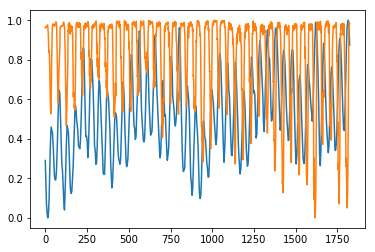

In [27]:
    plt.plot(OHC_300_ORAS4_sum_norm)
    plt.plot(SIC_ERAI_sum_norm)
    print(month_cycle[:130])

# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [28]:
    print ('*******************          prepare input tensor for LSTM           *********************')
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_size = 3
    hidden_size = 4
    batch_size = 1
    output_size = 2
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 4000
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # standard LSTM input dimension
    # [sequence_length(time step), batch_size, input_size]
    # example : x = torch.autograd.Variable(torch.randn(6, 3, 5))
    # prepare input array for LSTM input -> dimension
    # take 3 year as test data
    test_year = 3
    print ('******************* create input tensor with single-input dimension   *********************')
    SIC = SIC_ERAI_sum_norm[1:-test_year*12*4+1].reshape(len(SIC_ERAI_sum_norm[1:-test_year*12*4+1]),1,1)
    #SIV = SIV_PIOMASS_norm[:-test_year*12].reshape(len(SIV_PIOMASS_norm[:-test_year*12]),1,1)
    #time = time_series[:-test_year*12].reshape(len(time_series[:-test_year*12]),1,1)
    #year = year_cycle[:-test_year*12].reshape(len(year_cycle[:-test_year*12]),1,1)
    #month = month_cycle[:-test_year*12].reshape(len(month_cycle[:-test_year*12]),1,1)
    #weight_loss_3D = weight_loss[1:-test_year*12*4+1].reshape(len(weight_loss[1:-test_year*12*4+1]),1,1)
    print ('*******************   create input tensor with multi-input dimension   *********************')
    # create variables
    # create variables
    x_input = np.vstack((SIC_ERAI_sum_norm[:-test_year*12*4],
                         OHC_300_ORAS4_sum_norm[:-test_year*12*4],
                         month_cycle[:-test_year*12*4])).T #hstack,dstack
    x_input = x_input.reshape(len(month_cycle[:-test_year*12*4]),1,input_size)
    print ('*******************   create training tensor with multi-input dimension  *********************')
    y_train_stack = np.vstack((SIC_ERAI_sum_norm[1:-test_year*12*4+1],
                               OHC_300_ORAS4_sum_norm[1:-test_year*12*4+1])).T #hstack,dstack
    y_train_stack = y_train_stack.reshape(len(month_cycle[:-test_year*12*4]),1,input_size-1)
    print ('*******************   create tensors  *********************')
    x_var = torch.autograd.Variable(torch.Tensor(x_input))
    y_var = torch.autograd.Variable(torch.Tensor(y_train_stack))

*******************          prepare input tensor for LSTM           *********************
*******************  create basic dimensions for tensor and network  *********************
1.0.1.post2
Is CUDA available? False
******************* create input tensor with single-input dimension   *********************
*******************   create input tensor with multi-input dimension   *********************
*******************   create training tensor with multi-input dimension  *********************
*******************   create tensors  *********************


In [29]:
    print ('*******************  preview of input tensor  *********************')
    #plt.plot(SIC_ERAI_sum)
    #print(SIC_ERAI_sum_norm[:-test_year*12])
    print(x_input.shape)
    print(x_input[:,:,:])
    #plt.plot(SIC[:,0,0],label="SIC")
    #plt.plot(SIV[:,0,0],label="SIV")
    #plt.plot(x_input[:,0,1],label="month")
    #plt.legend()

*******************  preview of input tensor  *********************
(1680, 1, 3)
[[[ 0.96240979  0.29024236  1.        ]]

 [[ 0.96117595  0.25760558  1.        ]]

 [[ 0.96151937  0.22496879  1.        ]]

 ...

 [[ 0.9663912   0.67955644 12.        ]]

 [[ 0.9803751   0.65064805 12.        ]]

 [[ 0.98028221  0.62173967 12.        ]]]


In [ ]:
#     print ('*******************  module for calculating accuracy  *********************')
#     def accuracy(out, labels):
#         outputs = np.argmax(out, axis=1)
#     return np.sum(outputs==labels)/float(labels.size)

In [ ]:
    print ('*******************  run LSTM  *********************')
    # choose training data
    y_train = y_var
    # initialize our model
    model = deepclim.deepSeries.LSTM(input_size, hidden_size, batch_size=batch_size,
                                     output_dim=output_size, num_layers=num_layers)
    loss_fn = torch.nn.MSELoss(size_average=False)
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(loss_fn)
    print(optimiser)
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()

        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        model.hidden = model.init_hidden()
        #model.hidden2 = model.init_hidden2()
    
        # Forward pass
        y_pred = model(x_var)
        
        # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
        # Please Make Sure y_pred & y_train have the same dimension
        loss = loss_fn(y_pred, y_train)
        #print(y_pred.shape)
        #print(y_train.shape)
        # print loss at certain iteration
        if t % 200 == 0:
            print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
    
    torch.save(model, os.path.join(output_path,'lstm_{}.pkl'.format(region_name))) # save lstm model

*******************  run LSTM  *********************
LSTM(
  (lstm): LSTM(3, 4)
  (linear): Linear(in_features=4, out_features=2, bias=True)
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
##############################################################
##################  start training loop  #####################
##############################################################
Epoch  0 MSE:  4852.91357421875


/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch  200 MSE:  486.0369567871094
Epoch  400 MSE:  146.17723083496094
Epoch  600 MSE:  116.28215026855469
Epoch  800 MSE:  105.00052642822266
Epoch  1000 MSE:  95.84330749511719
Epoch  1200 MSE:  88.38618469238281
Epoch  1400 MSE:  82.38426971435547
Epoch  1600 MSE:  77.0644760131836
Epoch  1800 MSE:  71.49778747558594
Epoch  2000 MSE:  64.88970947265625
Epoch  2200 MSE:  56.77399826049805
Epoch  2400 MSE:  47.702064514160156
Epoch  2600 MSE:  36.431983947753906


In [10]:
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # the model learn from time series and try to predict the next time step based on the previous time series
    print ('*******************************  one step ahead forecast  *********************************')
    print ('************  the last {} years of total time series are treated as test data  ************'.format(test_year))
    data_predict = np.vstack((SIC_ERAI_sum_norm[0],
                              T2M_ERAI_mean_norm[0])).T # first month is taken from original data as starting point
    new_input = np.vstack((SIC_ERAI_sum_norm[:-test_year*12],
                           T2M_ERAI_mean_norm[:-test_year*12])).T # predicted variables before year of prediction
    for i in np.arange(1,len(SIC_ERAI_sum_norm),1): # here i is actually the time step (index) of prediction, we use var[:i] to predict var[i]
        # Clear stored gradient
        model.zero_grad()
        # Don't do this if you want your LSTM to be stateful
        # Otherwise the hidden state should be cleaned up at each time step for prediction (we don't clear hidden state in our forward function)
        # see example from (https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py)
        model.hidden = model.init_hidden()
        
        # using training series before the time of prediciton
        # using predicted data after the time of prediction
        if i <= (len(SIC_ERAI_sum_norm)-test_year*12):
            # prepare predictor (variables follow the same order as )
            x_pred = np.vstack((SIC_ERAI_sum_norm[0:i],
                                T2M_ERAI_mean_norm[0:i],
                                month_cycle[0:i])).T
            x_pred = x_pred.reshape(len(month_cycle[0:i]),1,input_size)
            #print(x_pred.shape)
            x_var_pred = torch.autograd.Variable(torch.Tensor(x_pred),requires_grad=False)
        
            # make prediction
            last_pred = model.forward(x_var_pred)
            last_pred = last_pred[-1,:,:].data.numpy()
            data_predict = np.vstack((data_predict, last_pred))
            #print(last_pred)
            
            if i == (len(SIC_ERAI_sum_norm)-test_year*12):
                new_input = np.vstack((new_input, last_pred))
        else:
            # Clear stored gradient
            model.zero_grad()
            # clear hidden state
            model.hidden = model.init_hidden()
            # prepare predictor
            # due to the shape of matrix, we need some transpose and concatenate
            x_pred = (np.vstack((new_input.T,month_cycle[0:len(new_input[:,0])]))).T
            x_pred = x_pred.reshape(len(new_input[:,0]),1,input_size)
            x_var_pred = torch.autograd.Variable(torch.Tensor(x_pred),requires_grad=False)
        
            # make prediction
            last_pred = model.forward(x_var_pred)
            last_pred = last_pred[-1,:,:].data.numpy()
            data_predict = np.vstack((data_predict, last_pred))
            #print(last_pred)
            new_input = np.vstack((new_input, last_pred))

##############################################################
###################  start prediction loop ###################
##############################################################
*******************************  one step ahead forecast  *********************************
************  the last 3 years of total time series are treated as test data  ************


In [12]:
    print ('*******************  evaluation matrix  *********************')
    # The prediction will be evaluated through RMSE against climatology
    def RMSE(x,y):
        """
        Calculate the RMSE. x is input series and y is reference series.
        """
        rmse = np.sqrt((x-y)**2)
    
        return rmse

    # calculate the RMSE error of predictied years
    error_pred = np.sum(RMSE(data_predict[-test_year*12*4:,0],SIC_ERAI_sum_norm[-test_year*12*4:]))
    print ("RMSE = {}".format(error_pred))

*******************  evaluation matrix  *********************
RMSE = 1.9769703856266507


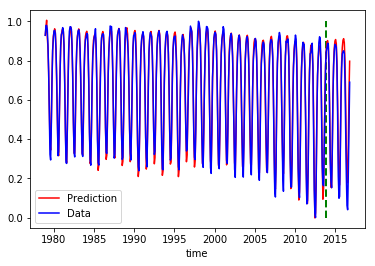

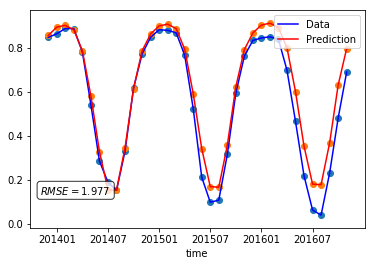

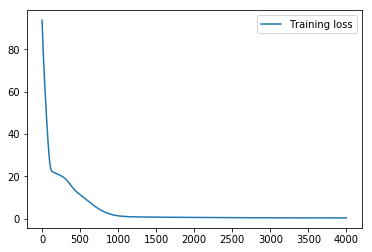

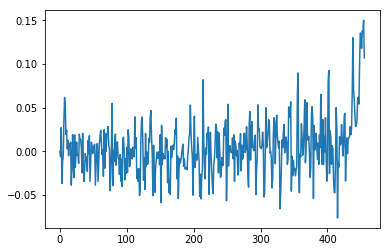

In [13]:
    # visualization
    index_plot = np.arange(len(SIC_ERAI_sum_norm))
    year_index = np.arange(1980,2017,5)
    # repeat climatology as reference
    climatology = np.tile(seansonal_cycle_SIC,len(year_ERAI))
    # create index
    print ("*******************  Predicted Full Series  **********************")
    fig1 = plt.figure()
    plt.vlines(index_plot[-test_year*12*4],0,1,colors='g',linestyle='dashed',linewidth=2)
    plt.plot(index_plot, data_predict[:,0], 'r',label="Prediction") #[:,0] is SIC
    plt.plot(index_plot, SIC_ERAI_sum_norm, 'b',label="Data")
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    #plt.plot(y_train[:,0,0].detach().numpy(), label="Data")
    #plt.plot(y_train[:,0,0].detach().numpy(), label="Training")
    plt.xlabel('time')
    plt.xticks(np.arange(12*4+1,len(index_plot)+1,60*4),year_index)
    plt.legend()
    plt.show()
    fig1.savefig(os.path.join(output_path,'SIC_{}_ERAI_LSTM_pred_full.png'.format(region_name)),dpi=300)
    
    print ("*******************  Prediction with testing sets only  **********************")
    # include text box in the figure
    text_content = '$RMSE=%.3f$ ' % (error_pred)
    fig0 = plt.figure()
    plt.plot(index_plot[-test_year*12*4:], SIC_ERAI_sum_norm[-test_year*12*4:], 'b',label="Data")
    plt.scatter(index_plot[-test_year*12*4:],SIC_ERAI_sum_norm[-test_year*12*4:])
    plt.plot(index_plot[-test_year*12*4:], data_predict[-test_year*12*4:,0], 'r',label="Prediction")
    plt.scatter(index_plot[-test_year*12*4:], data_predict[-test_year*12*4:,0])
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    #plt.plot(y_train[:,0,0].detach().numpy(), label="Data")
    #plt.plot(y_train[:,0,0].detach().numpy(), label="Training")
    plt.xlabel('time')
    plt.xticks(np.arange(35*12*4+1,38*12*4+1,6*4),(['201401', '201407',
                                                    '201501', '201507',
                                                    '201601', '201607']))
    plt.legend(loc=1)
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax = plt.gca()
    ax.text(0.03,0.2,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.show()
    fig0.savefig(os.path.join(output_path,'SIC_{}_ERAI_LSTM_pred.png'.format(region_name)),dpi=300)    
    
    print ("*******************  Loss with time  **********************")
    fig2 = plt.figure()
    plt.plot(hist, label="Training loss")
    plt.legend()
    plt.show()
    fig2.savefig(os.path.join(output_path,'SIC_{}_ERAI_LSTM_pred_error.png'.format(region_name)),dpi=300)
    
    print ("*******************  Other variables (Prediction with testing sets only) **********************")
    fig3 = plt.figure()
    plt.plot(index_plot[-test_year*12*4:], OHC_300_ORAS4_sum_norm[-test_year*12*4:], 'b',label="Data")
    plt.scatter(index_plot[-test_year*12*4:],OHC_300_ORAS4_sum_norm[-test_year*12*4:])
    plt.plot(index_plot[-test_year*12*4:], data_predict[-test_year*12*4:,1], 'r',label="Prediction")
    plt.scatter(index_plot[-test_year*12*4:], data_predict[-test_year*12*4:,1])
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    #plt.plot(y_train[:,0,0].detach().numpy(), label="Data")
    #plt.plot(y_train[:,0,0].detach().numpy(), label="Training")
    plt.xlabel('time')
    plt.xticks(np.arange(35*12*4+1,38*12*4+1,6*4),(['201401', '201407',
                                                    '201501', '201507',
                                                    '201601', '201607']))
    plt.legend(loc=1)
    #props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax = plt.gca()
    #ax.text(0.03,0.2,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.show()
    fig3.savefig(os.path.join(output_path,'OHC_{}_ERAI_LSTM_pred.png'.format(region_name)),dpi=300)  

In [ ]:
#     print ('*******************  run linear regression  *********************')
#     model = LinearReg()
#     # construct loss function and an optimizer.
#     criterion = torch.nn.MSELoss(size_average=False)
#     optimizer = torch.optim.SGD(model.parameters(),lr=0.01) # learning rate (lr)
#     #####################
#     # Train Loop
#     #####################
#     for epoch in range(num_epoch):
#         # predict y by fit x through linear regression
#         y_predict = model(SIV_var)
#         # compute and print loss
#         loss = criterion(y_predict,y_train)
        
#         # backpropagation and gradient descend (fix steps)
#         # Zero out gradient, else they will accumulate between epochs
#         optimizer.zero_grad()
    
#         # Backward pass
#         loss.backward()

#         # Update parameters
#         optimizer.step()        